(notebook_id)=
# Lasso regression with block updating

:::{post} Feb 10, 2022
:tags: pymc3.Exponential, pymc3.Laplace, pymc3.Metropolis, pymc3.Model, pymc3.Normal, pymc3.Slice, pymc3.Uniform, regression
:category: beginner
:author: Chris Fonnesbeck, Michael Osthege, Thomas Wiecki, Raul Maldonado, Lorenzo Toniazzi
:::

In [1]:
%matplotlib inline
import arviz as az
import numpy as np
import pymc as pm

from matplotlib import pylab

print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v4.0.0b2


In [2]:
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")

Sometimes, it is very useful to update a set of parameters together. For example, variables that are highly correlated are often good to update together. In PyMC block updating is simple. This will be demonstrated using the parameter `step` of `{class}<pymc.sample>`.

Here we have a [LASSO regression model](https://en.wikipedia.org/wiki/Lasso_(statistics)#Bayesian_interpretation) where the two coefficients are strongly correlated. Normally, we would define the coefficient parameters as a single random variable, but here we define them separately to show how to do block updates.

First we generate some fake data.

In [3]:
x = rng.standard_normal(size=(3, 30))
x1 = x[0] + 4
x2 = x[1] + 4
noise = x[2]
y_obs = x1 * 0.2 + x2 * 0.3 + noise

Then define the random variables.

In [4]:
lam = 3000

with pm.Model() as model:
    sigma = pm.Exponential("sigma", 1)
    tau = pm.Uniform("tau", 0, 1)
    b = lam * tau
    beta1 = pm.Laplace("beta1", 0, b)
    beta2 = pm.Laplace("beta2", 0, b)

    mu = x1 * beta1 + x2 * beta2

    y = pm.Normal("y", mu=mu, sigma=sigma, observed=y_obs)

For most samplers, including `{class}<pymc.Metropolis>` and `{class}<pymc.HamiltonianMC`, simply pass a list of variables to sample as a block. This works with both scalar and array parameters.

In [5]:
with model:
    initvals = pm.find_MAP()

    step1 = pm.Metropolis([beta1, beta2])

    step2 = pm.Slice([sigma, tau])

    idata = pm.sample(10000, step=[step1, step2], initvals=initvals)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>CompoundStep
>>Metropolis: [beta1]
>>Metropolis: [beta2]
>CompoundStep
>>Slice: [sigma]
>>Slice: [tau]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 31 seconds.
The number of effective samples is smaller than 10% for some parameters.


We conclude by plotting the sampled marginals and the joint distribution of `beta1` and `beta2`.

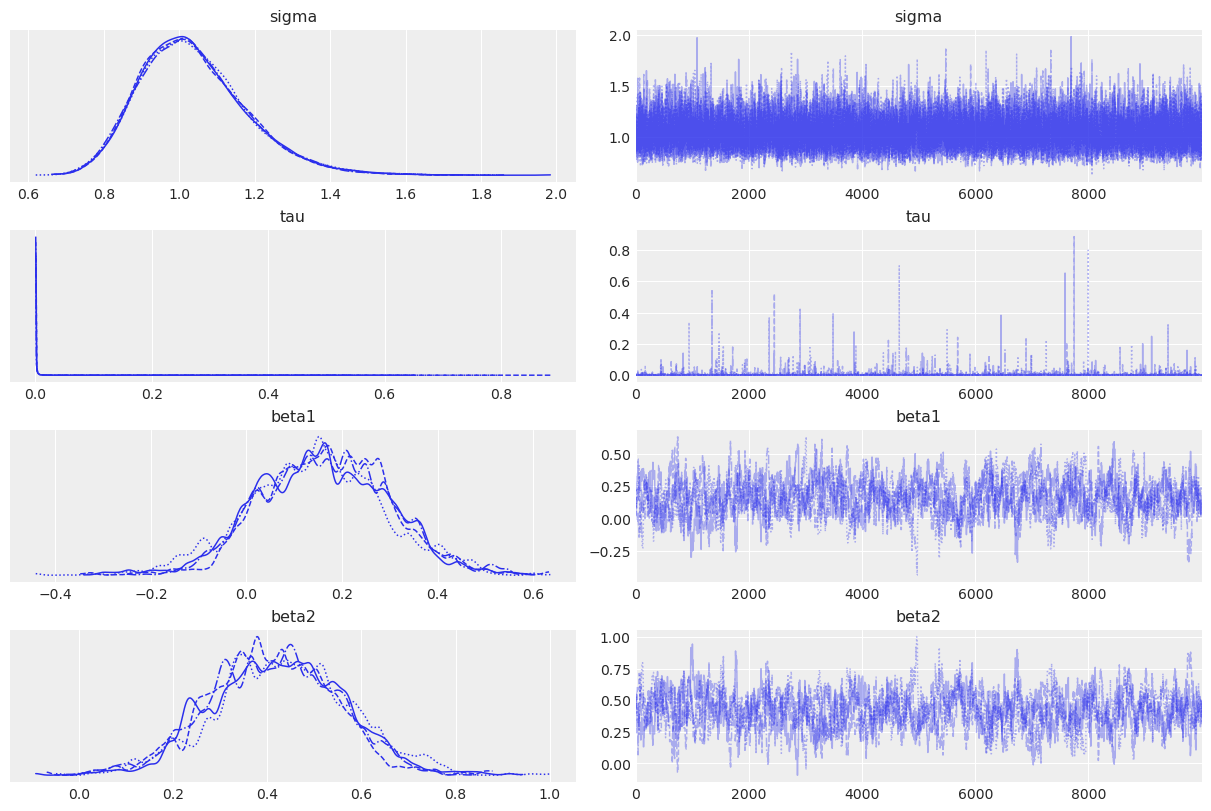

In [6]:
az.plot_trace(idata);

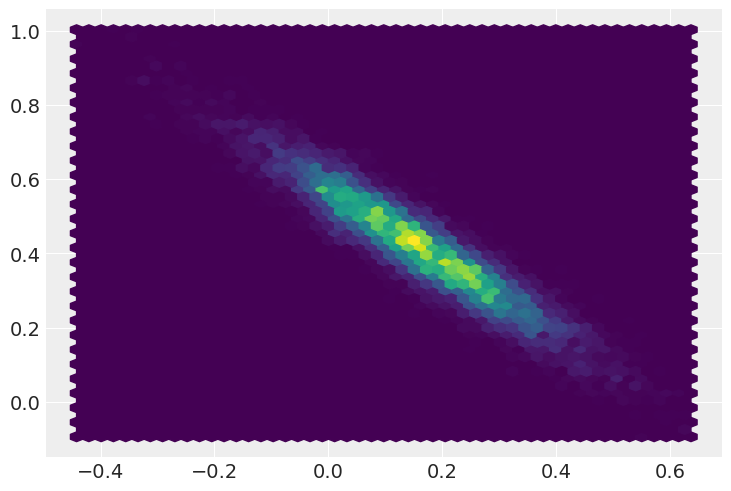

In [7]:
pylab.hexbin(idata.posterior["beta1"], idata.posterior["beta2"], gridsize=50);

## Autorship

* Authored by Chris Fonnesbeck in Dec, 2020
* Updated by Raul Maldonado in Jan, 2021
* Updated by Raul Maldonado in Mar, 2021
* Reexecuted by Thomas Wiecki and Michael Osthege in Jan, 2022 ([pymc-examples#264](https://github.com/pymc-devs/pymc-examples/pull/264))
* Updated by Lorenzo Toniazzi in Feb, 2022 ([pymc-examples#??](https://github.com/pymc-devs/pymc-examples/pull/??))

## Watermark

In [8]:
%load_ext watermark
%watermark -n -u -v -iv -w -p aesara,aeppl,xarray

Last updated: Sat Feb 05 2022

Python implementation: CPython
Python version       : 3.9.9
IPython version      : 7.29.0

aesara: 2.3.6
aeppl : 0.0.18
xarray: 0.20.2

numpy     : 1.22.1
matplotlib: 3.5.1
arviz     : 0.11.4
pymc      : 4.0.0b2

Watermark: 2.3.0



:::{include} ../page_footer.md
:::